## [Description](#Description_)
## [Research](#Research_)
## [Setup](#Setup_)
## [0. Разминка](#0._Разминка_)

# Лабораторная работа 5. Временные ряды. <span id=Description_></span>


Результат лабораторной работы &mdash; отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете так же должен быть код, однако чем меньше кода, тем лучше всем: нам &mdash; меньше проверять, вам &mdash; проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу &mdash; 10 баллов. Сдавать задание после указанного в lk срока сдачи нельзя. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, нам необходима ссылка на источник).



## Research <span id=Research_></span>

https://mse.msu.ru/wp-content/uploads/2021/03/Введение-в-анализ-временных-рядов-1.pdf

## Setup <span id=Setup_></span>

### Markdown

In [1]:
def make_new_markdown_section_with_link(section, header="##", do_print=True):
    section_id = section.replace(" ", "_") + "_"
    section_link = f"{header} [{section}](#{section_id})"
    section_header = f"{header} {section} <span id={section_id}></span>"
    if do_print:
        print(section_link + "\n" + section_header)
    return section_link, section_header

def make_several_sections(
    section_names=(
        "Description",
        "Imports",
        "Globals",
        "Setup",
        "Data",
        "Data exploration",
        "Model",
        "Training",
        "Results",
    )
):
    links, headers = zip(
        *[
            make_new_markdown_section_with_link(sn, do_print=False)
            for sn in section_names
        ]
    )
    print("\n".join(links + ("",) + headers))

### Imports

In [629]:
%load_ext nb_black

import catboost
import os
import numpy as np
import pandas as pd
import types
from zipfile import ZipFile

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(palette="Set2")

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

import statsmodels
import statsmodels.api as sm
import pmdarima as pm
from tbats import TBATS

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


ModuleNotFoundError: No module named 'catboost'

<IPython.core.display.Javascript object>

## 0. Разминка<span id=0._Разминка_></span>

#### Задача 1. [2 балла]

Даны временные ряды
* $y_t = 2 + y_{t-1} - 0.5 y_{t-2} + 0.5 y_{t-3} + \varepsilon_t - 2\varepsilon_{t-1} + \varepsilon_{t-2}$,
* $y_t = -1 - y_{t-2} - 0.25 y_{t-4} + \varepsilon_t - \varepsilon_{t-3}$,

где $\varepsilon_t$ &mdash; гауссовский белый шум со средним 0 и дисперсией $\sigma^2$, который так же не зависит от $y_{t-i}, i \geqslant 1$. 

**1.** Являются ли ряды стационарными? 

**2.** Определите тип процесса в терминах ARIMA($p, d, q$).

**3.** Если временной ряд стационарен, вычислите математическое ожидание и дисперсию $y_t$.

---
Определим лаговый оператор:

$\operatorname{L}y_t := y_{t−1}$

Ряд называется стационарным, если:

1. $\operatorname{E}y_t \equiv const$
2. $\operatorname{cov}(y_t, y_{t+h}) = \gamma(h)$

Второе свойство можно записать как $\operatorname{cov}(L^h y_t, y_t) = \gamma(h)$. Простейший пример стационарного ряда - это белый шум $\epsilon_t$, для которого:

1. $\operatorname{E}y_t = 0$ 
2. $\operatorname{cov}(y_t, y_{t+h}) = \sigma^2\mathbb{1}[h == 0]$

Модель $y_t \sim \text{ARMA}(p,q)$ определяется как:

$\displaystyle{
y_t = 
\mu + \sum_{i=1}^{p}\phi_i y_{t-i} + \epsilon_t + \sum_{i=1}^{q}\theta_i\epsilon_{t-i} =
\mu + \sum_{i=1}^{p}\phi_i L^i y_{t} + \epsilon_t + \sum_{i=1}^{q}\theta_iL^i\epsilon_{t},
}$

где $\epsilon_t$ есть белый шум. Перепишем это в более однородном виде:

$\displaystyle{
y_t  - \sum_{i=1}^{p}\phi_i L^i y_{t} = \mu + \epsilon_t + \sum_{i=1}^{q}\theta_i L^i\epsilon_{t}\\
\phi(L)y_t = \mu + \theta(L)\epsilon_{t}
}$

где

$\displaystyle{
\phi(x) =  1 - \sum_{i=1}^{p}\phi_i x^i\\
\theta(x) =  1 - \sum_{i=1}^{q}\theta_i x^i
}$

Для модели $\text{ARMA}$ справедливо утверждение, что она определяет стационарный ряд $\Leftrightarrow$ все корни многочлена $\phi(x)$ больше 1 по модулю. Воспользуемся этим для решения пункта 1:

**1.** 

$\displaystyle{
y_t = 2 + y_{t-1} - 0.5 y_{t-2} + 0.5 y_{t-3} + \varepsilon_t - 2\varepsilon_{t-1} + \varepsilon_{t-2}\\
\phi(x) = 1 - x + 0.5x^2 - 0.5x^3 = (1 - x)(1 - 0.5x^2) = (1-x)(1 - \sqrt{0.5}x)(1 + \sqrt{0.5}x)
}$

Поскольку $\phi(x)$ имеет корень 1, то ряд $y_t$ не стационарен.

$\displaystyle{
y_t = -1 - y_{t-2} - 0.25 y_{t-4} + \varepsilon_t - \varepsilon_{t-3} \\
\phi(x) = 1 + x^2 + 0.25 x^4 = (1 + 0.5x^2)^2 = (1 + i\sqrt{0.5}x)^2 (1 - i\sqrt{0.5}x)^2
}$

Корни $\phi(x)$ - это $\pm i\sqrt{2}$, они по модулю равны $\sqrt{2} > 1$, значит ряд стационарен.

**2.**

Операция дифференцирования ряда обозначается как 

$\displaystyle{
\Delta y_t = y_t - y_{t-1} = y_t - \operatorname{L} y_t = (1 - \operatorname{L}) y_t
}$

Модель $y_t \sim \text{ARIMA}(p,k,q)$ определяется как:

1. k - минимальный порядок дифференцирования, что $\Delta^k y_t$ есть стационарный ряд
2. $\Delta^k y_t \sim \text{ARMA}(p,q)$

Второй ряд есть $\text{ARIMA}(4,0,3)$. Чтобы понять тип первого ряда, нужно его продиффреницировать:

$\displaystyle{
\Delta y_t = 2 - 0.5 \Delta y_{t-2} + \Delta \varepsilon_t - \Delta \varepsilon_{t-1}\\
\phi(x) = 1 + 0.5x^2 = (1 + i\sqrt{0.5}x)(1 - i\sqrt{0.5}x)
}$

Корни $\phi(x)$ по модулю равны $\sqrt{2}$, значит первый ряд есть $\text{ARIMA}(2,1,1)$.

**3.**

Математическое ожидание второго ряда:

$\displaystyle{
\operatorname{E}y_t =
\operatorname{E}(-1 - y_{t-2} - 0.25 y_{t-4} + \varepsilon_t - \varepsilon_{t-3}) =
-1 - \operatorname{E}y_{t} - 0.25 \operatorname{E}y_{t}\\
\operatorname{E}y_t = -\frac{1}{2.25} = -\frac{4}{9}
}$

Посчитаем дисперсию с учетом того, что для стационарной $\text{ARMA}$ справедливо следующее утверждение:

$\operatorname{cov}(y_t, \varepsilon_{t+h}) = 0, h > 0$

$\displaystyle{
\operatorname{Var}y_t = 
\operatorname{Var}(-1 - y_{t-2} - 0.25 y_{t-4} + \varepsilon_t - \varepsilon_{t-3}) =
\operatorname{Var}y_{t} + \frac{1}{16} \operatorname{Var}y_{t} + \sigma^2 + \sigma^2 
+0.25\operatorname{cov}(y_{t-2}, y_{t-4}) + \operatorname{cov}(y_{t-2}, \varepsilon_{t-3})\\
 \frac{1}{16} \operatorname{Var}y_{t} + 2\sigma^2
+0.25\gamma(2) + \operatorname{cov}(y_{t}, \varepsilon_{t-1})\\
}$

Поскольку $y_{t}$ не зависит ни от $\varepsilon_{t-1}$, ни от $y_{t-1}$, то $\operatorname{cov}(y_{t}, \varepsilon_{t-1}) =0$, получаем:

$\operatorname{Var}y_t = -32 \sigma^2 -4\gamma(2)$

$\gamma(2) =
\operatorname{cov}(y_{t-2}, y_t) =
\operatorname{cov}(y_{t-2}, -1 - y_{t-2} - 0.25 y_{t-4} + \varepsilon_t - \varepsilon_{t-3}) =
-\operatorname{Var}y_t -0.25 \gamma(2)\\
\operatorname{Var}y_t = -1.25 \gamma(2) = -32 \sigma^2 -4\gamma(2)\\
\gamma(2) = -\frac{128}{11}\sigma^2\\
\operatorname{Var}y_t = \frac{160}{11}\sigma^2
$

## 1. Данные

В качестве данных рассмотрим известный набор данных с параметрами погоды в одной точке земной поверхности, доступный нам с частотой дискретизации в 10 минут. Описание данных доступно по <a href="https://keras.io/examples/timeseries/timeseries_weather_forecasting/">ссылке</a>.

Скачаем данные

In [8]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
!wget {uri}

--2023-04-23 17:48:10--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.17.144, 216.58.212.16, 172.217.169.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.17.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12,94M  6,96MB/s    in 1,9s    

2023-04-23 17:48:13 (6,96 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13568290/13568290]



In [21]:
zip_path = "jena_climate_2009_2016.csv.zip"
assert os.path.exists(zip_path), f"Download {uri}"

zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

Немного преобразуем данные, рассмотрев максимальное значение каждой величины за сутки.

In [45]:
weather_df = pd.read_csv(csv_path)
weather_df["Date"] = pd.to_datetime(weather_df["Date Time"], format="%d.%m.%Y %H:%M:%S")

weather_df_daily = weather_df.set_index("Date").resample('D').max().reset_index()
del weather_df_daily["Date Time"]
weather_df_daily = weather_df_daily.set_index('Date')
weather_df_daily.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date,,,,,,,,,,,,,,
2009-01-01,1000.87,-4.17,269.00,-5.36,94.8,4.48,4.09,0.49,2.55,4.09,1318.81,2.51,3.63,357.9
2009-01-02,1002.65,-2.12,271.12,-3.88,96.3,5.22,4.58,0.70,2.86,4.59,1298.51,3.87,6.13,358.8
2009-01-03,1002.49,-0.82,272.59,-6.09,93.9,5.75,3.87,2.86,2.41,3.86,1323.70,3.64,4.88,357.2
2009-01-04,992.93,-0.63,273.55,-2.26,93.9,5.83,5.17,1.53,3.27,5.25,1274.06,3.95,7.13,257.0
2009-01-05,997.54,-1.44,272.89,-2.45,93.2,5.49,5.10,0.83,3.23,5.18,1332.38,7.81,10.88,358.9


Теперь в каждой строчке датасета мы имеем максимальные значения за сутки. Например, в строчке `2012-12-22` в колонке `T (degC)` записана максимальная температура по Цельсию за данные сутки.

**Глобальная цель** в данном домашнем задании &mdash; прогнозирование максимальной температуры на день вперед. Например, 22 декабря нужно построить прогноз значения `T (degC)` за 23 декабря, используя при этом любые данные до 22 декабря включительно, но не используя никакие данные начиная с 23 декабря.

*Замечание*. Обратите внимание, что значения от 22 декабря доступны только по окончанию этого дня, плюс накладные расходы на поставку данных. Но для упрощения ситуации, допустим, что данные приходят мгновенно, а прогноз от нас ждут в начале суток 23 декабря, так что мы успеем подучить данные от 22 декабря, преобразовать их в признаки и применить нашу модель.

#### Задача 2. [0.25 балла]

Выделите таргет в отдельную переменную `pd.Series`. Значением таргета от 22 декабря должна быть максимальная температура за сутки 23 декабря, то есть то, что мы хотим прогнозировать.

In [518]:
def simplify_columns(df) -> list[str]:
    return [c.split("(")[0].strip() for c in df.columns]


def get_target_series(df, prediction_horizon=1):
    target = df["T"]
    target = target.shift(freq=pd.Timedelta(days=-prediction_horizon))
    target = target.loc[target.index.intersection(df.index)]
    return target

<IPython.core.display.Javascript object>

Разделите данные на обучающие и тестовые. В качестве тестового отрезка времени возьмите данные за последний год. Обратите внимание, что за 2016-10-26 и 2016-10-27 данных нет.

In [519]:
def get_train_test_indices(
    target: pd.Series,
) -> tuple[pd.DatetimeIndex, pd.DatetimeIndex]:
    timestamp_threshold = target.index[-1] - pd.Timedelta(days=365)
    train_mask = target.index < timestamp_threshold
    train_index = target.index[train_mask]
    test_index = target.index[~train_mask]
    return train_index, test_index

<IPython.core.display.Javascript object>

In [520]:
def build_data_namespace(df):
    df.columns = simplify_columns(df)
    target = get_target_series(df)
    train_index, test_index = get_train_test_indices(target)

    data = types.SimpleNamespace()
    data.train_df = df.loc[train_index]
    data.test_df = df.loc[test_index]
    data.train_target = target.loc[train_index]
    data.test_target = target.loc[test_index]

    return data


DATA = build_data_namespace(weather_df_daily)
print(list(DATA.__dict__))

['train_df', 'test_df', 'train_target', 'test_target']


<IPython.core.display.Javascript object>

## 2. Простая аналитика

#### Задача 3. [1 балл]

Произведите визуализацию всех временных рядов.

In [523]:
def visualize_time_series_overview(df):
    plt.title("Overview")
    for column in df:
        df[column].plot(alpha=0.5)
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")


def visualize_time_series_separately(df, n_cols=3, figsize_width=12):
    n_rows = int(0.5 + len(df.columns) / n_cols)
    figsize_height = figsize_width // n_cols * n_rows
    fig, axes = plt.subplots(
        ncols=n_cols, nrows=n_rows, figsize=(figsize_width, figsize_height)
    )

    for column, axis in zip(df.columns, fig.axes):
        plt.sca(axis)
        plt.title(column)
        df[column].plot()

    for axis in fig.axes[len(df.columns) :]:
        plt.sca(axis)
        plt.axis("off")

    plt.tight_layout()

<IPython.core.display.Javascript object>

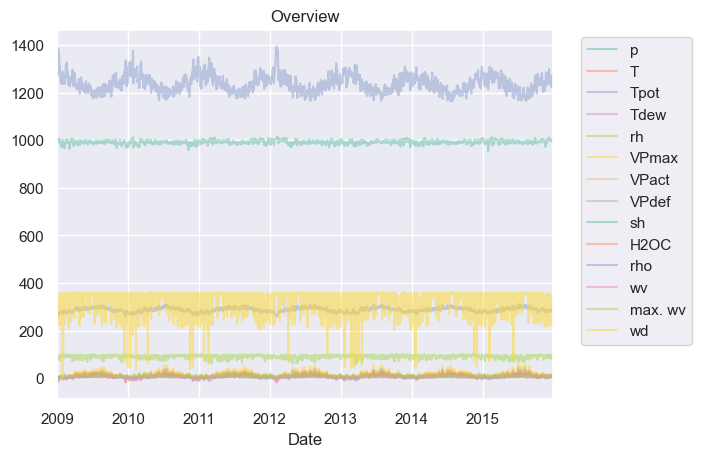

<IPython.core.display.Javascript object>

In [524]:
visualize_time_series_overview(DATA.train_df)

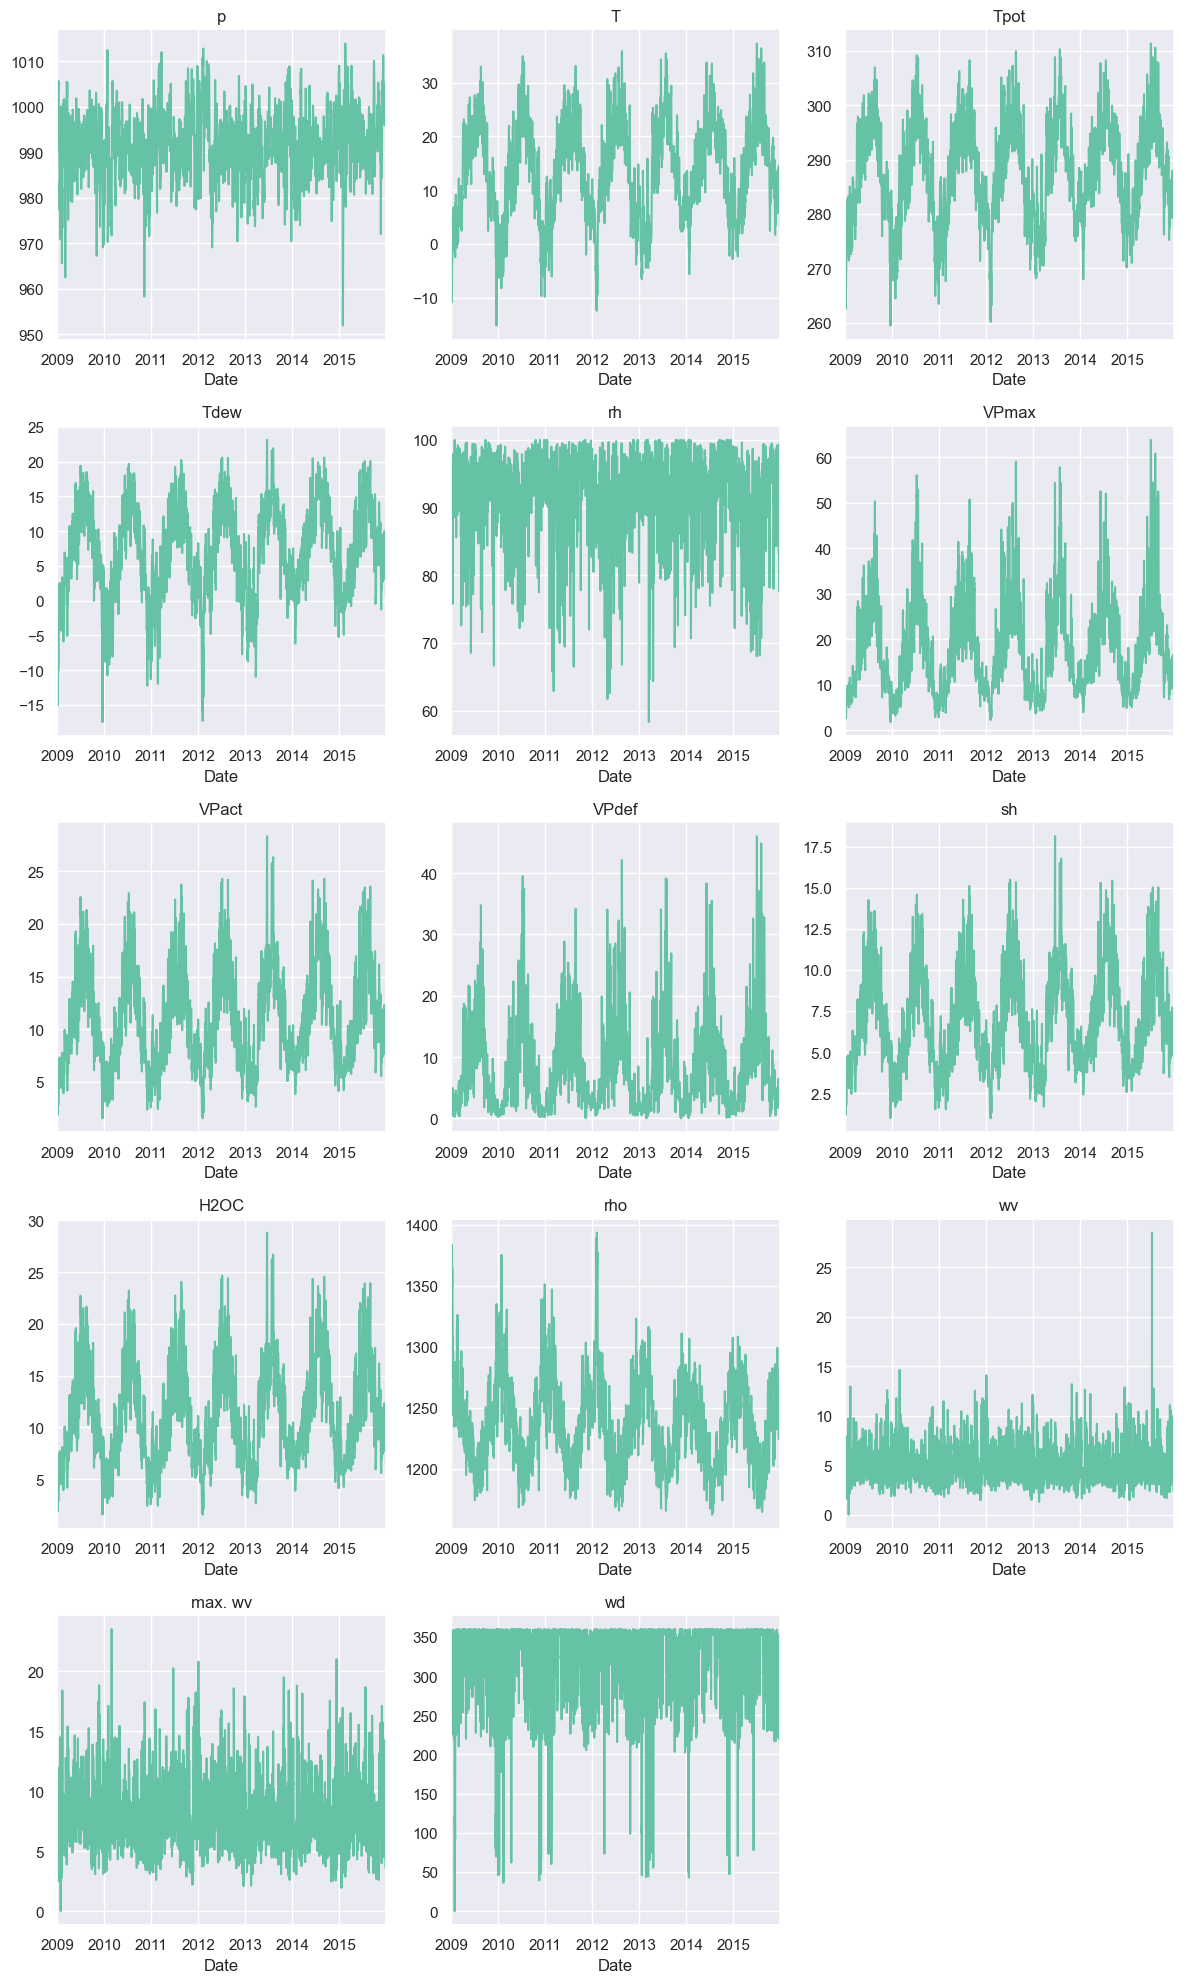

<IPython.core.display.Javascript object>

In [525]:
visualize_time_series_separately(DATA.train_df)

Имеются ли в данных выбросы? Если да, отфильтруйте данные. Не перестарайтесь, фильтруйте только более менее очевидные выбросы.

Подумайте над тем, какие значения ставить вместо выбросов. Учтите, что не все модели могут обрабатывать пропуски.

---

Я увидел только один очевидный выброс - то, что в один день средняя скорость ветра превысила максимальную:

In [526]:
(DATA.train_df["wv"] > DATA.train_df["max. wv"]).sum()

1

<IPython.core.display.Javascript object>

Ограничим скорость ветра максимальной:

In [527]:
DATA.train_df["wv"] = DATA.train_df[["wv", "max. wv"]].min(axis="columns")

<IPython.core.display.Javascript object>

#### Задача 4. [1 балл]

Посчитайте матрицу корреляций по всем временным рядам без сдвигов (т.е. $corr(x_t, y_t)$) и визуализируйте ее

<Axes: >

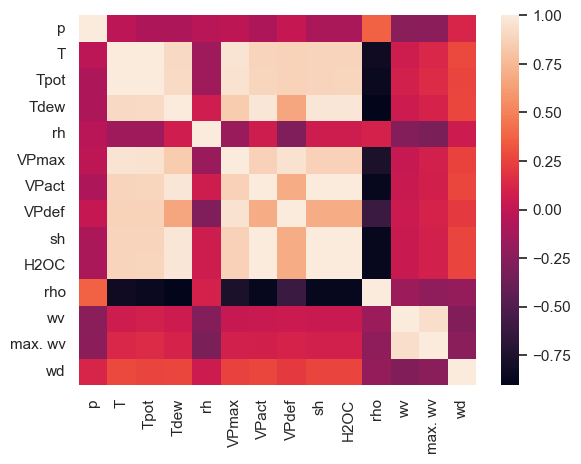

<IPython.core.display.Javascript object>

In [528]:
sns.heatmap(DATA.train_df.corr())

Постройте коррелограмму временного ряда температуры

''

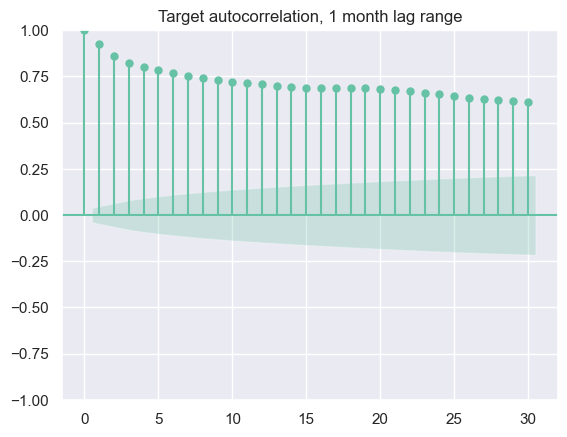

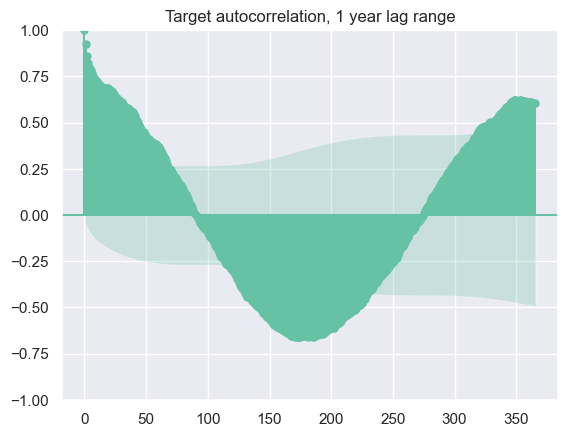

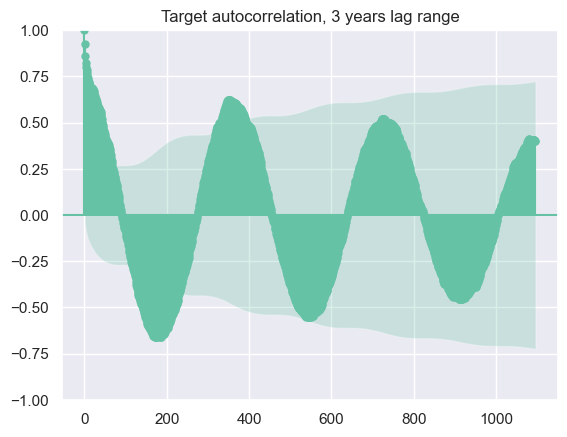

<IPython.core.display.Javascript object>

In [529]:
statsmodels.graphics.tsaplots.plot_acf(
    DATA.train_target, lags=30, title="Target autocorrelation, 1 month lag range"
)
statsmodels.graphics.tsaplots.plot_acf(
    DATA.train_target, lags=365, title="Target autocorrelation, 1 year lag range"
)
statsmodels.graphics.tsaplots.plot_acf(
    DATA.train_target,
    lags=365 * 3,
    title="Target autocorrelation, 3 years lag range",
)
;

По временному ряду температуры выполните STL-разложение и визуализируйте полученные компоненты

''

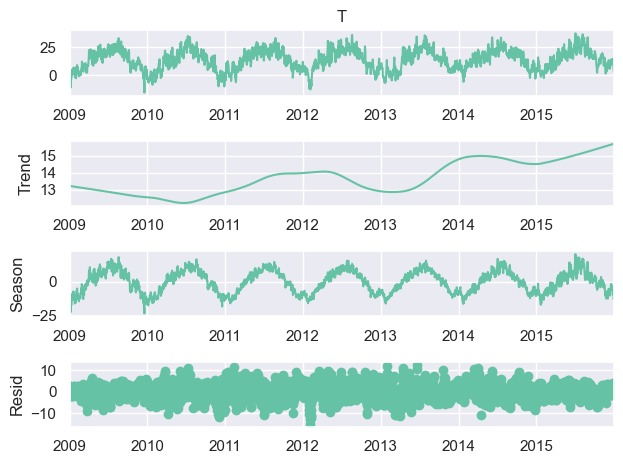

<IPython.core.display.Javascript object>

In [530]:
statsmodels.tsa.seasonal.STL(DATA.train_target, period=365).fit().plot()
;

**Выводы:**

- Временной ряд температуры значимо автокоррелирован с лагом вплоть до двух месяцев
- Температура также сильно коррелирует с:
    - Tpot, что неудивительно, ведь это просто та же температура в Кельвинах
    - Tdew - температура, скорректированная относительно влажности
    - VPmax, VPact и VPdef, sh, H2OC - показатели, также связанные с влажностью
- Температура имеет выраженную сезонность с периодом в год
- Температура имеет значимый положительный тренд

## 3. Качество

#### Задача 5. [0.5 балла]

Напишите функции вычисления качества решения в задачи прогнозирования.
Качество решения будем описывать при помощи нескольких метрик качства:
  * mean_squared_error
  * mean_absolute_error
  * mean_absolute_percentage_error
  * median_absolute_error

In [531]:
def mean_squared_error(expected: np.array, predicted: np.array) -> float:
    return ((expected - predicted) ** 2).mean()


def mean_absolute_error(expected: np.array, predicted: np.array) -> float:
    return np.abs(expected - predicted).mean()


def mean_absolute_percentage_error(expected: np.array, predicted: np.array) -> float:
    return (np.abs(expected - predicted) / (np.abs(expected) + 1e-7)).mean() / 100


def median_absolute_error(expected: np.array, predicted: np.array) -> float:
    return np.median(np.abs(expected - predicted))


def compute_metrics(predicted: pd.Series, split="train") -> dict[str, float]:
    expected = DATA.train_target if split == "train" else DATA.test_target
    index = expected.index.intersection(predicted.index)
    expected = expected.loc[index].values
    predicted = predicted.loc[index].values
    return dict(
        mean_squared_error=mean_squared_error(expected, predicted),
        mean_absolute_error=mean_absolute_error(expected, predicted),
        mean_absolute_percentage_error=mean_absolute_percentage_error(
            expected, predicted
        ),
        median_absolute_error=median_absolute_error(expected, predicted),
    )

<IPython.core.display.Javascript object>

По всем данным посчитайте метрики качества baseline-решения &mdash; прогноз константой (т.е. прогноз последним доступным значением самой прогнозируемой величины), для горизонтов прогнозирования 1, 2, 3.

In [532]:
def get_constant_prediction(df, target_index: pd.DatetimeIndex) -> pd.Series:
    return pd.Series(index=target_index, data=df["T"].values)

<IPython.core.display.Javascript object>

In [533]:
def build_constant_prediction_metrics_dataframe(
    prediction_horizon_range, split="train"
) -> pd.DataFrame:
    df = DATA.train_df if split == "train" else DATA.test_df
    metrics = []
    for prediction_horizon in prediction_horizon_range:
        prediction_index = df.index + pd.Timedelta(days=prediction_horizon)
        prediction = get_constant_prediction(df, prediction_index)
        metrics.append(compute_metrics(prediction, split=split))

    return pd.DataFrame(
        {i: m for i, m in zip(prediction_horizon_range, metrics)}
    ).rename_axis(index=f"{split} metrics", columns="Prediction horizon in days")

<IPython.core.display.Javascript object>

''

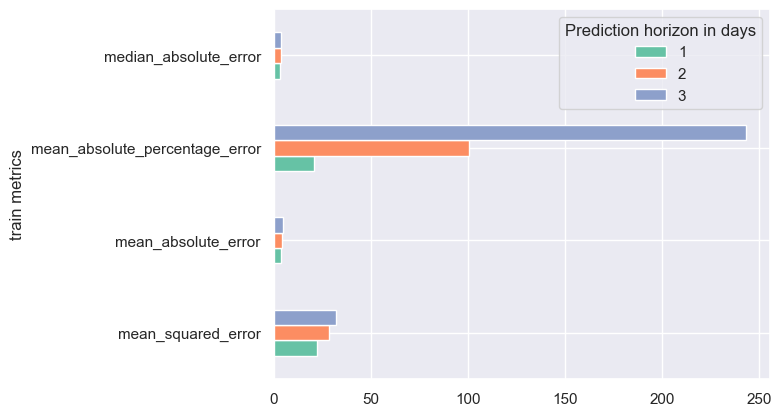

<IPython.core.display.Javascript object>

In [534]:
build_constant_prediction_metrics_dataframe(prediction_horizon_range=[1, 2, 3]).plot(
    kind="barh"
)
;

Посчитайте эти же метрики по скользящим окнам из 4 и 8 недель. Иначе говоря, 
* сначала считаете качество по окну $[t+1, t+\Delta t]$, используя в качестве прогноза $y_t$,
* затем по окну $[t+2, t+\Delta t+1]$, используя в качестве прогноза $y_{t+1}$,
* и так далее.

Постройте графики изменения качества прогноза со временем.

''

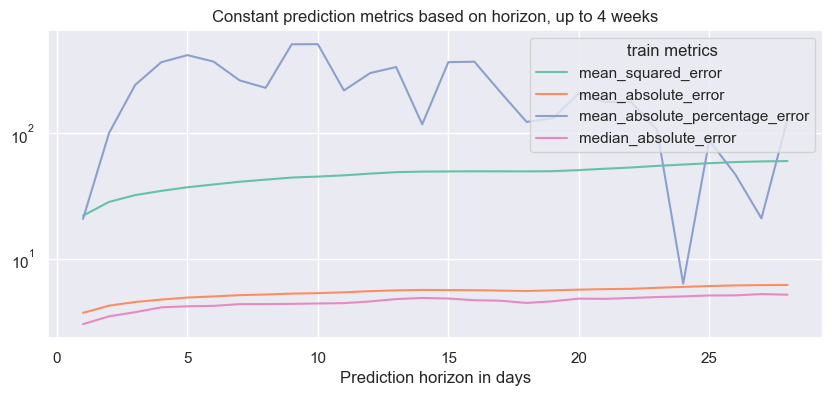

<IPython.core.display.Javascript object>

In [535]:
build_constant_prediction_metrics_dataframe(
    prediction_horizon_range=range(1, 4 * 7 + 1)
).T.plot(
    logy=True,
    figsize=(10, 4),
    title="Constant prediction metrics based on horizon, up to 4 weeks",
)
;

''

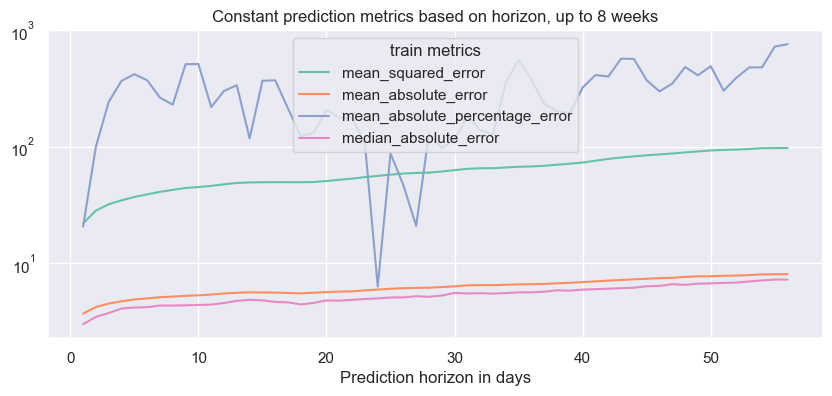

<IPython.core.display.Javascript object>

In [536]:
build_constant_prediction_metrics_dataframe(
    prediction_horizon_range=range(1, 8 * 7 + 1)
).T.plot(
    logy=True,
    figsize=(10, 4),
    title="Constant prediction metrics based on horizon, up to 8 weeks",
)
;

**Выводы:**

Константное предсказание хорошо работает вплоть до предсказаний на 3 дня вперед, дальше его качество сильно падает.

#### Задача 6. [0.5 балла]

Скользящая валидация с фиксированным размером обучающего периода (*см. в лекциях вариант 1*) реализована в <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html">sklearn.model_selection.TimeSeriesSplit</a>:

In [537]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv_1 = TimeSeriesSplit(n_splits=5, max_train_size=1000, test_size=8 * 7, gap=70)

for train_index, test_index in ts_cv_1.split(weather_df_daily):
    ...

<IPython.core.display.Javascript object>

Если вы будете валидировать свои модели по данной схеме, то вы сможете получить наилучшую модель, но не сможете получить несмещённую оценку её качества.
Это важно когда заказчик хочет не только самую лучшую модель по качеству, но и оценку качества этой модели на исторических данных.

Для этого случая имеется альтернативный nested-способ валидации, реализацию которого можно найти по <a href="https://github.com/roelbertens/time-series-nested-cv">ссылке</a>.

Реализуйте nested кросс-валидацию.

In [538]:
def nested_cross_validation(index, train_size, test_size, n_splits=5):
    if n_splits > 1:
        split_offset = (len(index) - train_size - test_size) // (n_splits - 1)
    else:
        split_offset = 0

    for split_id in range(n_splits):
        train_begin = split_id * split_offset
        train_index = index[train_begin : train_begin + train_size]

        test_begin = train_begin + train_size
        test_index = index[test_begin : test_begin + test_size]

        yield train_index, test_index

<IPython.core.display.Javascript object>

In [539]:
def test_nested_cross_validation(df):
    train_size = 1000
    test_size = 200

    for (
        train_index,
        test_index,
    ) in nested_cross_validation(df.index, train_size=train_size, test_size=test_size):
        assert len(train_index.intersection(test_index)) == 0
        assert len(train_index) == train_size
        assert len(test_index) == test_size
        assert max(train_index) < min(test_index)

    print("OK")


test_nested_cross_validation(weather_df_daily)

OK


<IPython.core.display.Javascript object>

## 4. Сведение к задаче регрессии

Для получения признакового описания для конкретного момента времени обычно применяют различные оконные функции к таблице данных, что позволяет сэкономить память и вычисления.
Но нужно помнить, что нельзя допустить просачивание информации из будущего, т.к. такие признаки вы не сможете вычислить в продакшне.




#### Задача 7. [0.5 балла]

Вычислите простые признаки вида описательных статистик (сумма, максимум, минимум, стандартное отклонение) по нескольким размерам окон. Признаки можно вычислять не только по температуре, но и по сопутствующим временным рядам.

In [594]:
def compute_window_stats(train_df, stat_name: str, window_size, window_offset=0):
    train_df = train_df.shift(freq=pd.Timedelta(days=window_offset))
    window = train_df.rolling(pd.Timedelta(days=window_size))
    stats_df = getattr(window, stat_name)()

    stats_df.columns = [
        f"{c} {stat_name} in window of size {window_size}"
        + (f" {window_offset} days ago" if window_offset else "")
        for c in stats_df
    ]
    return stats_df

<IPython.core.display.Javascript object>

In [625]:
def build_features_dataframe(
    df,
    column_stat_window_size_window_offset_tuples=[
        ("T", "mean", 1, 0),
        ("T", "mean", 3, 0),
        ("T", "mean", 7, 0),
        ("T", "mean", 7, 365),
        ("T", "mean", 30, 365),
        ("T", "std", 7, 0),
        ("VPmax", "mean", 1, 0),
        ("VPmax", "mean", 3, 0),
        ("VPmax", "mean", 7, 0),
        ("VPmax", "mean", 7, 365),
        ("VPmax", "mean", 30, 365),
        ("VPmax", "std", 7, 0),
        ("wd", "mean", 1, 0),
    ],
):
    stats_dfs = []
    for (
        column,
        stat_name,
        window_size,
        window_offset,
    ) in column_stat_window_size_window_offset_tuples:
        stats_dfs.append(
            compute_window_stats(
                df[[column]],
                stat_name=stat_name,
                window_size=window_size,
                window_offset=window_offset,
            )
        )

    return pd.concat(stats_dfs, axis="columns", join="inner").dropna()

<IPython.core.display.Javascript object>

In [628]:
DATA.train_features = build_features_dataframe(DATA.train_df)
DATA.train_features.head()

,T mean in window of size 1,T mean in window of size 3,T mean in window of size 7,T mean in window of size 7 365 days ago,T mean in window of size 30 365 days ago,T std in window of size 7,VPmax mean in window of size 1,VPmax mean in window of size 3,VPmax mean in window of size 7,VPmax mean in window of size 7 365 days ago,VPmax mean in window of size 30 365 days ago,VPmax std in window of size 7,wd mean in window of size 1
Date,,,,,,,,,,,,,
2010-01-01,-2.84,0.55,1.830000,-4.170,-4.170,2.962814,4.95,6.526667,7.090000,4.480,4.480,1.461438,359.5
2010-01-02,-3.49,-2.32,0.608571,-3.145,-3.145,3.164803,4.72,5.166667,6.511429,4.850,4.850,1.486948,350.9
2010-01-03,-1.56,-2.63,0.144286,-2.370,-2.370,3.217664,5.45,5.040000,6.304286,5.150,5.150,1.524323,357.9
2010-01-04,-3.77,-2.94,-0.891429,-1.935,-1.935,3.130652,4.62,4.930000,5.844286,5.320,5.320,1.468478,358.6
2010-01-05,-3.55,-2.96,-1.531429,-1.836,-1.836,3.154074,4.70,4.923333,5.581429,5.354,5.354,1.487744,355.9


<IPython.core.display.Javascript object>

#### Задача 8. [0.5 балла]

Обучите градиентый бустинг и обычный многослойный перцептрон с использованием написанного скользящего контроля. Посчитайте качество.

Постройте визуализируйте полученные прогнозы на графике, сравнив их с истинными значениями ряда. Отдельно постройте также график тестового интервала с целью увеличения масштаба графика.

#### Задача 9. [1 балл]

Генерировать признаки на этапе знакомства с данными &mdash; не очень интересное занятие.
В отрасли предпринято несколько попыток автоматизировать этот этап.

С помощью библиотеки <a href="https://tsfresh.com/">tsfresh</a> можно довольно быстро сгенерировать большое количество признаков на основе сырых данных временных рядов. Например, по скользящему окну с помощью можно вычислить статистики вида минимум, максимум, среднее, количество пиков и т.д.

Ознакомьтесь с данной библиотекой и сгенерируйте признаковое описание. Обратите внимание на функции
* `roll_time_series`
* `extract_features`

Сколько признаков вы получили? Как побороться с большим числом признаков?

Обучите модель, посчитайте ее качество и постройте график прогноза.

**Выводы:**

## 5. ARIMA-подобные модели

#### Задача 10. [1.5 балла]

Обучите модель ARIMA, 
* используя сопутствующие временные ряды в качестве экзогенных факторов,
* используя знания о сезонности,
* подобрав оптимальные гиперпараметры.

*Замечания.*
* Используйте `pmdarima.auto_arima`, которая автоматически подберет гиперпараметры, *см. семинар*.
* Обучение может быть *слишком* вычислительно затратным. Начинайте тестировать код на очень маленьких данных, затем постепенно увеличивайте размер данных.
* Обучение встроенной сезонности может не получиться. В таком случае можно попробовать передать значения за предыдущие сезоны как экзогенные факторы, или же моделировать сезонность рядами Фурье. 

Обучите модель, посчитайте ее качество и постройте график прогноза *вместе с предсказательным интервалом*.

Напечатайте саммари модели (`summary()`). Что и как вы можете проинтерпретировать?

#### Задача 11. [1 балл]

Обучите модель TBATS, используя знания о сезонности. Выполните те же операции, что и для ARIMA.

**Выводы:**

## 6. Итоговое сравнение

#### Задача 12. [0.25 балла]

Составьте итоговую таблицу сравнения качества прогнозов всех рассмотренных моделей по всем метрикам. Постройте график прогнозов для лучших моделей.

**Выводы:**